# Neural Net Example

This example is partially based on [Stanford CS231n neural network case study](http://cs231n.github.io/neural-networks-case-study/).

In this notebook we will look at how to create, train, and use a neural network in Python. We will be using a neural network for 3-class classification problem, similar to the iris data, where there are three possible classes for our output value y. 

To compute the gradient for the backpropagation algorithm, we will be using a tool called autograd. [autograd](https://github.com/HIPS/autograd) is a Python package for **algorithmic differentiation**. It allows you to automatically compute the derivative of functions written in (nearly) native code. This makes it really easy to compute derivatives for things like gradients of complex non-linear functions in neural networks. Under the hood, it is also using reverse mode autodiff (which is just backpropagation). To use autograd, you jus tneed to add it to your cs490 Anaconda environment using the following command:

`conda install -c conda-forge autograd`


### Setup


In [1]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Create Data Set
First we are going to create some data to use for our neural network. We are going to generate a dataset with 3 classes (i.e., three possible y values) and 100 data points per class. We are going to distribute our classes using a non-linear radial basis, ensuring that our data will not be linearly separable (making for a more interesting example!).

(-1, 1)

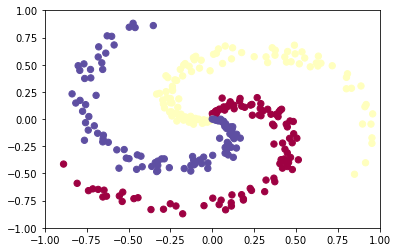

In [2]:
np.random.seed(0)

n = 2 # dimensionality--number of input features in X
points_per_class = 100 # number of points per class
num_classes = 3 # number of classes

m = points_per_class*num_classes

X = np.zeros((m,n))
y = np.zeros(m, dtype='uint8')

# generate our radial data for each class
for j in range(num_classes):
    
    inds = range(points_per_class*j, points_per_class*(j+1))

    # Generate radius and angle for each point
    r = np.linspace(0.0, 1, points_per_class) # radius
    t = np.linspace(j*4,(j+1)*4,points_per_class) + np.random.randn(points_per_class)*0.2 # theta

    X[inds] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[inds] = j  # class label
    
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])

## Plotting setup
Here is a helper function `plot_model` that we can use to plot our classifier, since we aren't using the built-in functions from `mltools`.

In [3]:
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_test = np.c_[xx.ravel(), yy.ravel()]

def plot_model(scores):
    # Put the result into a color plot
    Z = scores.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

## Helper Functions for Non-Linearities

First, setup some functions for non-linear activation functions we may use in the neural network, together with their derivatives.

In [4]:

# ReLU: "rectified linear unit" nonlinearity
def relu(z):
    return np.maximum(0, z)

# Derivative of relu wrt its input (for backprop)
def relu_prime(z):
    d = np.zeros_like(z)
    d[z > 0] = 1.
    return d

# Logistic function (aka "sigmoid") nonlinearity
def logistic(z):
    return 1./(1+np.exp(-z))

# Derivative of logistic function wrt its input
def logistic_prime(z):
    p = logistic(z)
    return p*(1-p)

# Train a 2-Layer Neural Network Using Autograd

Here we will show a complete example of training a feed-forward neural network with one hidden layer using autograd for the backpropagation. First, we need to define a multiclass loss function for our model, since standard MSE is most applicable for 2 classes.

### Cross-Entropy Loss Function

We would like a multiclass loss function analogous to log loss for logistic regression. First, suppose we are operating on a single input $\mathbf{x}$ with class $y$, and we have computed class scores $s_1, \ldots, s_c$ for this example for each of $c$ classes. We first transform these scores to probabilities by the following trick, known as the "softmax" transformation:

$$
p_k = \frac{\exp(s_k)}{\sum_{k'} \exp(s_{k'})}
$$

We have first exponentiated the scores to make them positive, and then normalized them to sum to one, creating a probability distribution over the possible classes. 

Then, the appropriate generalization of log loss is for multiple classes is:

$$
L = - \sum_k \mathbb{I}\{y = k\} \log p_k
$$

Here the indicator function $\mathbb{I}\{y = k\}$ is equal to one when the true class $y$ is equal to $k$ and zero otherwise. Note that, like log loss, this simply picks out the negative log predicted probability for the correct class. This loss function is usually called the "cross-entropy" loss function, for reasons we will not dive into.

This is the loss on a single training example. Our overall loss function is an average of the cross-entropy loss over all training example:
$$
L = \frac{1}{m} \sum_{i=1}^m \Bigg(\sum_k -\mathbb{I}\{y^{(i)} = k\} \log p^{(i)}_k\Bigg)
$$

To train a model with automatic differentiation (autograd) for the gradient, all we need to do is write a routine to compute the loss, and then we can automatically compute the derivatives of the loss function with respect to parameters for gradient descent. Here is a complete example.

In [ ]:
import autograd.numpy as np  # Thinly wrapped version of numpy
from autograd import grad

# Initialize parameters randomly
h  = 100 # size of hidden layer (i.e., number of hidden nodes)

W1 = 0.01 * np.random.randn(n,h)  # random weights for x1 and x2 at each of our hidden nodes
b1 = np.zeros((1,h)) # w0 (i.e., the y intercept) for each of our hidden nodes
W2 = 0.01 * np.random.randn(h,num_classes) # random weight for each of the outputs of h1...h100 for each of our classes
b2 = np.zeros((1,num_classes)) # w0 (i.e., the y intercept) for each of our output nodes

# Select hyperparameters
iters      = 10000
step_size  = 1e-0 # alpha in gradient descent
lambda_val = 1e-3 # regularization strength

'''
Do entire feed-forward computation and compute loss function
'''
def compute_loss(params):
    W1, b1, W2, b2 = params
    
    # Compute scores
    hidden = relu(np.dot(X, W1) + b1)  # use the rectified linear activation function
    y_hats = np.dot(hidden, W2) + b2   # each y_hat is the probability of that class
    
    # Compute probabilities
    exp_scores = np.exp(y_hats)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute cross-entropy loss    
    logprob_correct_class = -np.log(probs[range(m),y])
    data_loss = np.sum(logprob_correct_class)/m    # cross-entropy
    
    # Compute regularization loss using L2 regularization avereaged over the layers
    reg_loss = 0.5 * lambda_val * (np.sum(W1*W1) + np.sum(W2*W2))
    
    return data_loss + reg_loss


# This is the gradient of the entire feedforward process (i.e., the full backpropagation result)
gradient = grad(compute_loss)

# Gradient descent loop
for i in range(iters):
  
    # Print diagnostic
    loss = compute_loss((W1, b1, W2, b2))    
  
    if i % 1000 == 0:
        print ("iteration %d: loss %f" % (i, loss))
        
    dW1, db1, dW2, db2 = gradient((W1, b1, W2, b2))
    
    # perform a parameter update
    W1 += -step_size * dW1
    b1 += -step_size * db1
    W2 += -step_size * dW2
    b2 += -step_size * db2


# predict the class with the highest probability
def predict(X):
    hidden = relu(np.dot(X, W1) + b1)
    y_hats = np.dot(hidden, W2) + b2
    pred = np.argmax(y_hats, axis=1)
    return pred

plot_model(predict(X_test))

##  Train a 2-Layer Neural Network  Using Backprop

Now, we will do the same thing but code the backpropagation ourselves (just as an example--really there is no reason NOT to use autograd). First, we need to define the gradient we are trying to solve.

### Derivative of Log-Loss with Respect to Scores

It is possible to show using calculations similar to the derivations of the gradient of log-loss that:

$$
\frac{dL}{ds_k} = 
\begin{cases}
p_k     & \text{if } y \neq k \\
p_k - 1 & \text{if } y = k
\end{cases}
$$

Computing these derivatives is the first step of backpropagation.

### Backprop through One Layer Using Matrix Multiplication

Our feed-forward computation is structured very efficiently through matrix multiplication. For example, one layer without any non-linearity looks like:

``` .python
S = np.dot(X, W) + b 
```

Here

* $X \in \mathbb{R}^{m \times n}$ is a data matrix (with feature vectors in rows),
* $W \in \mathbb{R}^{n \times c}$ is a matrix of weight vectors (one in each column), 
* $b \in \mathbb{R}^{1 \times c}$ is a row vector containing the biases/intercepts for each class. 

We have imagined that this is the first layer, so the inputs are the original inputs $X$. However, the same math holds true if we replace $X$ by a matrix $H$ where each row contains the outputs of the previous layer for a single input feature vector. 
Observe that we are simultaneously conducting feedforward for the entire batch of inputs represented by the rows of $X$. This makes it extremely efficient. Also, note that broadcasting is happening here with $b$, so the proper way to write this algebraically is:

$$
\newcommand{\del}{\partial}
S = X W + \mathbf{1}b
$$

Here, $\mathbf{1} \in \mathbb{R}^m$ is a vector of ones, so that the product $\mathbf{1}b$ is an $m \times c$ matrix (just like $XW$) that contains a copy of $b$ in each row. Now, suppose we have a loss function $L$ that depends on $S$, and we have already computed the partial derivative $\frac{\del L}{\del S}$, which has the same dimensions as $S$ ($m \times c$). Then, the backpropagated partial derivatives with respect to $X$, $W$, and $b$ are as follows:

$$
\begin{aligned}
\frac{\del L}{\del W} &= X^T \frac{\del L}{\del S} \\
\frac{\del L}{\del X} &= \frac{\del L}{\del S} W^T \\
\frac{\del L}{\del b} &= \mathbf{1}^T \frac{\del L}{\del S} 
\end{aligned}
$$

These follow from standard identities for derivatives with respect to matrices and vectors. Note that the left-multiplication $\mathbf{1}^T \frac{\del L}{\del S}$ by the ones vector simply adds along columns of $\frac{\del L}{\del S}$. Therefore, in code we would write:

``` .python
# dS = array holding dL/dS
dW = np.dot(X.T,  dS)       # dL/dW
dX = np.dot( dS, W.T)       # dL/dX
db = np.sum( dS, axis=0 )   # dL/db
```

In [ ]:
# Initialize parameters randomly

h  = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(n,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,num_classes)
b2 = np.zeros((1,num_classes))

# Select hyperparameters
iters      = 10000
step_size  = 1e-0 # alpha in gradient descent
lambda_val = 1e-3 # regularization strength

# Select nonlinearity
g       = relu 
g_prime = relu_prime

#g = logistic
#g_prime = logistic_prime

# Gradient descent loop
for i in range(iters):
  
    '''
    FORWARD PROPAGATION
    ''' 

    # Compute class scores
    hidden_layer = g(np.dot(X, W1) + b1)           # shape (m, h)
    y_hats       = np.dot(hidden_layer, W2) + b2   # shape (m, num_classes)

    # Compute class probabilities
    exp_scores = np.exp(y_hats)                    # shape (m, num_classes)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    # Compute the loss function
    logprob_correct_class = -np.log(probs[range(m),y])
    data_loss = np.sum(logprob_correct_class)/m                    # cross-entropy
    reg_loss = 0.5 * lambda_val * (np.sum(W1*W1) + np.sum(W2*W2))  # regularization
    loss = data_loss + reg_loss                                    # total          
    
    # Print diagnostic
    if i % 1000 == 0:
        print ("iteration %d: loss %f" % (i, loss))

        
    ''' 
    BACKWARD PROPAGATION
    '''

    # Compute gradient of cross-entropy wrt class scores
    dyhats = probs
    dyhats[range(m),y] -= 1
    dyhats /= m

    # Now backpropagate to get gradient of cross-entropy wrt parameters (W2,b2)
    # and hidden layer outputs 
    dW2     = np.dot(hidden_layer.T, dyhats)
    db2     = np.sum(dyhats, axis=0)
    dhidden = np.dot(dyhats, W2.T)
    
    # Backprop through the nonlinearity
    dhidden = dhidden * g_prime(hidden_layer)
    
    # Backprop to (W1,b1)
    dW1 = np.dot(X.T, dhidden)
    db1 = np.sum(dhidden, axis=0)

    # Add regularization gradient contribution
    dW2 += lambda_val * W2
    dW1 += lambda_val * W1
    
    '''
    UPDATE PARAMETERS
    '''
    
    # perform a parameter update for each parameter in our model using the derivatives
    W1 += -step_size * dW1
    b1 += -step_size * db1
    W2 += -step_size * dW2
    b2 += -step_size * db2

def predict(X):
    hidden_layer = g(np.dot(X, W1) + b1)
    y_hats = np.dot(hidden_layer, W2) + b2
    pred = np.argmax(y_hats, axis=1)
    return pred

plot_model(predict(X_test))

# Train Multi-Class Logistic Regression Using Backprop

This is a simpler model than the one above. You may wish to inspect this first if working through backprop. It is a one-layer neural network, or multi-class logistic regression.

In [ ]:
# Initialize parameters randomly
W = 0.01 * np.random.randn(n, num_classes)
b = np.zeros((1,num_classes))

# Gradient descent loop
iters = 200
step_size  = 1e-0
lambda_val = 1e-3 # regularization strength

for i in range(iters):

    '''
    FORWARD PROPAGATION
    '''
    
    # Compute class probabilities
    y_hats     = np.dot(X, W) + b     # shape (m, num_classes)
    exp_scores = np.exp(y_hats)       # shape (m, num_classes)
    probs      = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # shape (m, num_classes)

    # Compute the loss function
    logprob_correct_class = -np.log(probs[range(m),y])
    data_loss = np.sum(logprob_correct_class)/m    # cross-entropy
    reg_loss = 0.5 * lambda_val * np.sum(W*W)      # regularization
    loss = data_loss + reg_loss                    # total          
    
    # Print diagnostic
    if i % 10 == 0:
        print ("iteration %d: loss %f" % (i, loss))

        
    '''
    BACKWARD PROPAGATION
    '''

    # Compute gradient of cross-entropy wrt class scores
    dscores = probs
    dscores[range(m),y] -= 1
    dscores /= m                 # shape (m, num_classes)

    # Now backpropate get gradient of cross-entropy wrt parameters (W,b)
    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    # Add gradient of regularization term
    dW += lambda_val * W 


    '''
    UPDATE PARAMETERS
    '''

    W += -step_size * dW
    b += -step_size * db

# evaluate training set accuracy
scores = np.dot(X, W) + b
predicted_class = np.argmax(y_hats, axis=1)
print ('training accuracy: %.2f' % (np.mean(predicted_class == y)))

scores_test = np.dot(X_test, W) + b
pred = np.argmax(scores_test, axis=1)
plot_model(pred)